#### Gonna try something epic here

My idea is to create a function/script/ability to overlay a sankey diagram over a bus route to represent the ons/offs and current passenger load, all while being displayed on the map. Hopefully would include hover/tooltip capabilities as well. IDK really how I will start but heres to trying

I will try initially to use the E line to do this. I already have the segment data which will be helpful but the main reason I am using the eline data is that it is mostly straight!! This will help as I am developing for a few reasons.

##### Relevant resources 

https://python-visualization.github.io/folium   ---> folium docs

In [1]:
### Gonna start with the imports. Nothing weird don't freak out.
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely

import folium
import json
import branca.colormap as cm

pd.set_option('display.max_columns', None) ### This line makes all the columns display, rather than ellipses shorten

In [2]:
### import the e line data with segments

kcm_segment_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Routes_for_King_County_Metro___transitroute_line"
kcm_point_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Stops_for_King_County_Metro___transitstop_point"

all_kcm_segment_data = gpd.read_file(kcm_segment_data)
all_kcm_point_data = gpd.read_file(kcm_point_data)


In [3]:
### gonnna fabricate some data about the ons/offs/avg departing load. This isn't about reflecting reality at the current moment
## Stop list, south to north --> [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850]

##completely made up
## starting_stop_num: [boardings, alightings]

#type = dict

### E line stops
ridership_data_E = {
    7690: [12, 0],
    7710: [14, 6],
    7730: [13, 2],
    7750: [5, 20],
    7770: [8, 6],
    7790: [10, 14],
    7810: [3, 6],
    7850: [2, 7],
    7880: [1, 6],
    7900: [0, 3]
}



In [4]:
### route 14
ridership_data_14 = {
    11820: [7, 0],
    11840: [3, 3],
    11860: [5, 2],
    11870: [3, 4],
    11880: [2, 1],
    11890: [8, 3],
    11910: [2, 1],
    11920: [1, 3],
    11940: [4, 5],
    8530: [6, 2],
    3600: [3, 4],
    1500: [2, 5],
    1510: [4, 4],
    1530: [1, 2],
    1610: [0, 3]
 




}

In [5]:
### 8 line stops

ridership_data = {
    2672: [12, 0],
    2180: [13, 6],
    2200: [8, 2],
    2244: [11, 9],
    2245: [0, 3],
    2250: [8, 1],
    2255: [7, 2],
    2260: [8, 3],
    2262: [3, 8],
    2264: [4, 2],
    29268: [3, 7],
    29270: [10, 9]
    
}

In [6]:
### compiling a list of stops that I will use for this experiment. Mostly in a straight line and not too many of them.
#bus_stop_list = [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850, 7880]
bus_stop_list = list(ridership_data.keys())


stop_geometrys = all_kcm_point_data[all_kcm_point_data['STOP_ID'].isin(bus_stop_list)]
stop_geometrys = stop_geometrys[stop_geometrys['CURRENT_NE'] == 'IN SERVICE'] ## eliminating 3X stops


In [7]:
e_line_full_segment = all_kcm_segment_data[all_kcm_segment_data['ROUTE_NUM'] == 675] ##675 is the E line's route number

In [8]:
#stop_geometrys.explore()

### Ridership data stuffs

In [9]:
### This cell calculates the departing load from every stop!
departing_load = 0

for stop_num in ridership_data.keys():    
    current_boardings = ridership_data[stop_num][0]
    current_alightings = ridership_data[stop_num][1]

    departing_load = departing_load + current_boardings - current_alightings

    ridership_data[stop_num].append(departing_load)
    #print (f"stop_num - {stop_num}, current_boardings - {current_boardings}, current_alightings - {current_alightings}, departing_load - {departing_load}")

### Now its time to try and draw a line between each stop

In [10]:
### make a function enabling the #shortest_line function to work with just two points.

def shortest_line_between(geom1, geom2):
    return gpd.GeoSeries([geom1]).shortest_line(gpd.GeoSeries([geom2])).iloc[0]


In [11]:


## Making sure the stop geometrys data frame is in the proper order

stop_id_ordered_list = list(ridership_data.keys())

id_order = {id_: i for i, id_ in enumerate(stop_id_ordered_list)}
stop_geometrys['Ordered_Ids'] = stop_geometrys['STOP_ID'].map(id_order)

stop_geometrys = stop_geometrys.sort_values('Ordered_Ids')


In [12]:
#stop_geometrys

In [13]:
### generate a list of stops 
stop_geometry_dict = {}
for i in range(len(ridership_data.keys())):
    stop_geometry_dict[f"stop_number_{i}_geo"] = stop_geometrys.iloc[i]['geometry']

In [14]:
#segment_dictionary

num_stops = len(stop_geometry_dict)

segment_dict = {}

for j in range(0, num_stops-1):
    first_stop_loc = stop_geometry_dict[f"stop_number_{j}_geo"]
    second_stop_loc = stop_geometry_dict[f"stop_number_{j+1}_geo"]
    segment_dict[f"segment_{j}"] = shortest_line_between(first_stop_loc, second_stop_loc)

In [15]:
num_segments = len(segment_dict)

segment_gdf = gpd.GeoDataFrame(
                                {'starting_stop_id': bus_stop_list[:num_segments],
                                'ridership_data_dict':[ridership_data[stop_id] for stop_id in bus_stop_list[:num_segments]],
                                'geometry': [segment_dict[f"segment_{id}"] for id in range(num_segments)]},
                                geometry = 'geometry', crs = "EPSG:2926"
                              )


In [16]:
segment_gdf['segment_id'] = range(1, len(segment_gdf) + 1)

print (range(1, len(segment_gdf)))

range(1, 11)


In [17]:
avg_ons_list = []
avg_offs_list = []
avg_load_list = []

for i in range(len(segment_gdf)):
    value_trio = segment_gdf['ridership_data_dict'][i]
    avg_ons_list.append(value_trio[0])
    avg_offs_list.append(value_trio[1])
    avg_load_list.append(value_trio[2])




In [18]:
segment_gdf["boardings"] = avg_ons_list
segment_gdf["alightings"] = avg_offs_list
segment_gdf["departing_load"] = avg_load_list

In [19]:
#def color_function(feature):
    #departing_load = features["properties"]["departing_load"]
   # if (departing_load > 10):
   #     return "#ff0000"
    #else:
     #   return "#008000"

In [20]:
max_departing_load = segment_gdf['departing_load'].max()

In [21]:


print (departing_load)
mdl_pct = max_departing_load / 6
step = cm.StepColormap(
    ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#91cf60", "#1a9850",], vmin=0, vmax=max_departing_load, index=[3, mdl_pct, mdl_pct * 2, mdl_pct * 3, mdl_pct * 4, mdl_pct * 5, max_departing_load], caption="step"
)

step
    

35


In [22]:
def style_function_simple(features):
    departing_load = features["properties"]["departing_load"]
   
    #print (features["properties"]["departing_load"])
    return {
        'weight': departing_load,
        'color': step(departing_load),
        'opacity': 0.8,
        'lineCap': 'butt', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [23]:
mainline_tt = folium.GeoJsonTooltip(
    #fields = ['boardings', 'alightings', 'departing_load']
    fields = ['departing_load']
)

In [24]:
folium_map = folium.Map(location=[47.699389, -122.344733], zoom_start=14, tiles="cartodb positron")


folium.GeoJson(
    data = segment_gdf,
    style_function = style_function_simple,
    tooltip = mainline_tt
).add_to(folium_map)

In [25]:
segment_gdf.explore(column = 'segment_id')

In [26]:
folium_map

#### Ok now that the single line map is done...... it is time to ***attempt*** to make the boarding/alighting lines

In [27]:
#### use shapely.transform to generate new points?

In [28]:
shifted_stops_dict_alighting = {}
shifted_stops_dict_boarding = {}
counter = 0

alighting_segment_dict = {}
boarding_segment_dict = {}

for point in stop_geometrys['geometry']:
    counter = counter + 1

    ##generate shifted points
    alighting_shifted_point = shapely.transform(geometry=point, transformation=lambda x,y: (x + 700, y + 1000), interleaved=False)
    boarding_shifted_point = shapely.transform(geometry=point, transformation=lambda x,y: (x - 700, y - 1000), interleaved=False)

    ## generate segments using the shifted points
    alighting_segment_dict[f"offshot_segment_{counter}"] = shortest_line_between(point, alighting_shifted_point)
    boarding_segment_dict[f"offshot_segment_{counter}"] = shortest_line_between(point, boarding_shifted_point)
    

alighting_points_list = list(shifted_stops_dict_alighting.values())
boarding_points_list = list(shifted_stops_dict_boarding.values())

In [29]:
alighting_segments_gdf = gpd.GeoDataFrame(geometry = list(alighting_segment_dict.values()), crs = "EPSG:2926")
boarding_segments_gdf = gpd.GeoDataFrame(geometry = list(boarding_segment_dict.values()), crs = "EPSG:2926")

alighting_segments_gdf["associated_starting_stop_id"] = segment_gdf["starting_stop_id"]
alighting_segments_gdf["alightings"] = segment_gdf["alightings"]

boarding_segments_gdf["associated_starting_stop_id"] = segment_gdf["starting_stop_id"]
boarding_segments_gdf["boardings"] = segment_gdf["boardings"]

In [30]:
def boarding_style_function(features):
    boardings = features['properties']['boardings']
    #print (features['properties']['alightings'])
    #print (features['properties']['associated_starting_stop_id'])
    return {
        'weight': boardings,
        'color': '#a913cf',
        'lineCap': 'round', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [31]:
boarding_tt = folium.GeoJsonTooltip(
    fields = ['boardings']
)

In [32]:
def alighting_style_function(features):
    alightings = features['properties']['alightings']
    #print (features['properties']['alightings'])
    #print (features['properties']['associated_starting_stop_id'])
    return {
        'weight': alightings,
        'color': '#4978c4',
        'lineCap': 'round', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [33]:
alighting_tt = folium.GeoJsonTooltip(
    fields = ['alightings']
)

In [34]:
folium.GeoJson(
    data=alighting_segments_gdf,
    name="alighting_segments",
    style_function=alighting_style_function,
    tooltip = alighting_tt
).add_to(folium_map)

In [35]:
folium.GeoJson(
    data=boarding_segments_gdf,
    name="boarding_segments",
    style_function=boarding_style_function,
    tooltip = boarding_tt
).add_to(folium_map)

In [36]:
folium_map

In [37]:
#folium_map.save('E_line_ridership_display_test.html') #this line saves the map as an HTML file

### Ok now I have to try to figure out splitting the lines so they can look somewhat appropriate visually

In [38]:
### do I want to make a multiline string for the entire thing??

In [39]:
from shapely.geometry import LineString, MultiLineString
from shapely import ops

# 1. Define the coordinates for the main line and the branches.
# The branching point is where the two segments meet.
main_line = LineString([(0, 0), (5, 5)])
branch1 = LineString([(5, 5), (10, 10)])
branch2 = LineString([(5, 5), (10, 0)])

# 2. Combine the LineString objects into a MultiLineString.
# This represents a network of lines rather than a single, continuous path.
branched_multiline = MultiLineString([main_line, branch1, branch2])

print("Original geometries:")
print(f"Main line: {main_line.wkt}")
print(f"Branch 1: {branch1.wkt}")
print(f"Branch 2: {branch2.wkt}")
print("\nMultiLineString representation of the branched line:")
print(branched_multiline.wkt)

# To visualize this, the individual lines can be plotted separately,
# or you can use `shapely.ops.linemerge()` to simplify them where possible.
merged_lines = ops.linemerge(branched_multiline)
print("\nlinemerge() result (only merges end-to-end lines):")
print(merged_lines.wkt)

Original geometries:
Main line: LINESTRING (0 0, 5 5)
Branch 1: LINESTRING (5 5, 10 10)
Branch 2: LINESTRING (5 5, 10 0)

MultiLineString representation of the branched line:
MULTILINESTRING ((0 0, 5 5), (5 5, 10 10), (5 5, 10 0))

linemerge() result (only merges end-to-end lines):
MULTILINESTRING ((0 0, 5 5), (5 5, 10 10), (5 5, 10 0))


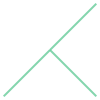

In [40]:
merged_lines